# Классификация Симпсонов

**Описание задачи:**

Сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. Необходимо классифицировать изображения персонажей, проживающих в Спрингфилде.


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Классификация-изображений" data-toc-modified-id="Классификация-изображений-1">Классификация изображений</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Установка-зависимостей-и-загрузка-данных" data-toc-modified-id="Установка-зависимостей-и-загрузка-данных-1.0.1">Установка зависимостей и загрузка данных</a></span></li><li><span><a href="#Построение-своей-архитектуры-нейросети" data-toc-modified-id="Построение-своей-архитектуры-нейросети-1.0.2">Построение своей архитектуры нейросети</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-1.0.3">Обучение</a></span></li><li><span><a href="#Валидация" data-toc-modified-id="Валидация-1.0.4">Валидация</a></span></li><li><span><a href="#Submit-на-Kaggle" data-toc-modified-id="Submit-на-Kaggle-1.0.5">Submit на Kaggle</a></span></li><li><span><a href="#Результаты--пользовательской-архитектуры" data-toc-modified-id="Результаты--пользовательской-архитектуры-1.0.6">Результаты  пользовательской архитектуры</a></span></li></ul></li></ul></li><li><span><a href="#Transfer-learning" data-toc-modified-id="Transfer-learning-2">Transfer learning</a></span><ul class="toc-item"><li><span><a href="#Использование-готовой-нейросети-&quot;из-коробки&quot;" data-toc-modified-id="Использование-готовой-нейросети-&quot;из-коробки&quot;-2.1">Использование готовой нейросети <strong>"из коробки"</strong></a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Результаты-исполользования-сети-из-коробки" data-toc-modified-id="Результаты-исполользования-сети-из-коробки-2.1.0.1">Результаты исполользования сети <strong>из коробки</strong></a></span></li></ul></li></ul></li><li><span><a href="#Готовая-сеть-как-Feature-Extractor" data-toc-modified-id="Готовая-сеть-как-Feature-Extractor-2.2">Готовая сеть как <strong>Feature Extractor</strong></a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Результаты-использования-архитектуры-сети-как-Feature-Extractor" data-toc-modified-id="Результаты-использования-архитектуры-сети-как-Feature-Extractor-2.2.0.1">Результаты использования архитектуры сети как <strong>Feature Extractor</strong></a></span></li></ul></li></ul></li><li><span><a href="#Fine-tuning-смешанный-способ" data-toc-modified-id="Fine-tuning-смешанный-способ-2.3">Fine tuning смешанный способ</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Результаты-Fine-Tuning---Unfreeze-15-last-layers" data-toc-modified-id="Результаты-Fine-Tuning---Unfreeze-15-last-layers-2.3.0.1">Результаты Fine Tuning - <strong>Unfreeze 15 last layers</strong></a></span></li></ul></li></ul></li><li><span><a href="#Differential-Learning-Rates" data-toc-modified-id="Differential-Learning-Rates-2.4"><strong>Differential Learning Rates</strong></a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Результаты-Fine-Tuning-Differential-Learning-Rates" data-toc-modified-id="Результаты-Fine-Tuning-Differential-Learning-Rates-2.4.0.1">Результаты Fine Tuning <strong>Differential Learning Rates</strong></a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Итоги" data-toc-modified-id="Итоги-3">Итоги</a></span></li></ul></div>

### Установка зависимостей и загрузка данных

In [1]:
import torch

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU')
else:
    print('CUDA is available!  Training on GPU')

CUDA is available!  Training on GPU ...


In [6]:
!nvidia-smi

Sun Nov 19 11:43:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [7]:
import pickle
import numpy as np
from skimage import io
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import PIL
import numpy as np


from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

from torch.optim import lr_scheduler



from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [8]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Ниже  исспользуем враппер над датасетом для удобной работы.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

Метод __getitem__ переопределяем для удобства работы с данной структурой данных. 

LabelEncoder используется для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому будут приводить их к одному размеру (метод  _prepare_sample)

In [9]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        # добавлены аугментации
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            transforms.CenterCrop(224),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
# определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train')
TEST_DIR = Path('./testset')

In [12]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
# Этот код создает два отсортированных списка файлов в формате JPEG
# метод rglob для рекурсивного поиска файлов с расширением .jpg внутри директории TRAIN_DIR. Метод rglob возвращает генератор,
# который генерирует пути ко всем файлам с указанным расширением внутри указанной директории и её поддиректорий.

In [13]:
# Создает список меток (labels), извлекаемых из родительских директорий каждого файла в списке train_val_files.
# Это делается с использованием генератора списков и метода path.parent.name, который возвращает имя родительской директории.
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)
len(train_val_labels), len(train_files), len(val_files)

(20933, 15699, 5234)

Обучающий датасет содержит 20933 изображения, от него 25% отделили для валидационной выборки.  
Из описания известно, что тестовая выборка будет сотоять из 990 изобр.

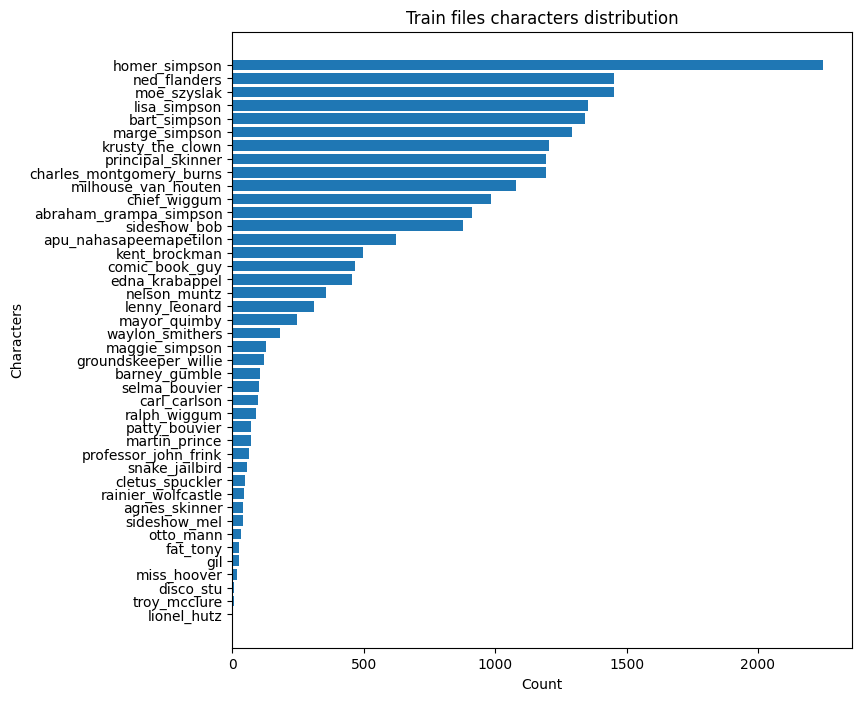

In [14]:
# распределение объектов по классам
counts = pd.Series(train_val_labels).value_counts()
plt.figure(figsize=(8,8))
plt.barh(counts.keys()[::-1], counts.sort_values(ascending=True))
plt.title('Train files characters distribution')
plt.xlabel('Count')
plt.ylabel('Characters')
plt.show();

В данных значительный дисбаланс классов. Допускаем, что в тестовой выборке будет аналогичное распределение, так как внизу списка редко появляющиеся в мультсериале герои.

In [15]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

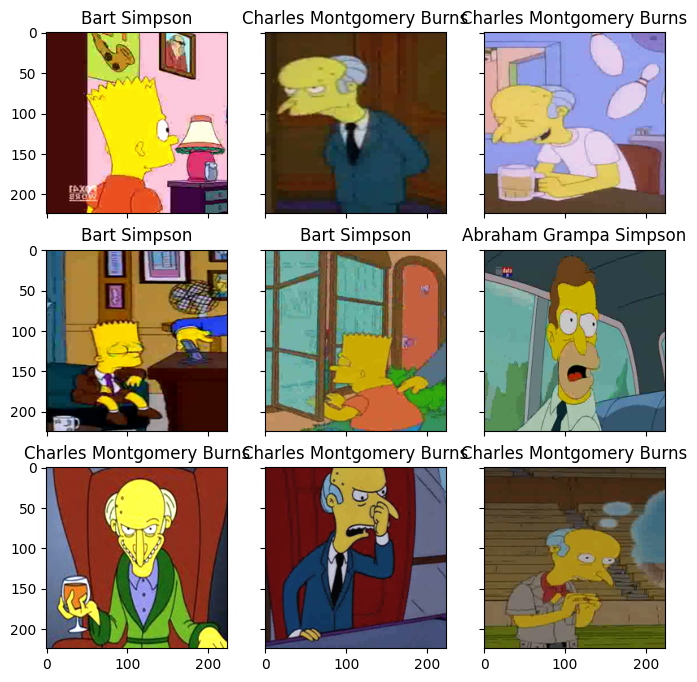

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
# Этот код выполняет преобразование метки (label) из формата, где слова разделены подчеркиванием и записаны в нижнем регистре,
# в формат, где каждое слово начинается с заглавной буквы и слова разделены пробелами.
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение своей архитектуры нейросети

За исходную простую архитектуру возьмём свёрточную нейронную сеть из 5 свёрточных слоёв. Доработаем её архитектуру и настроим параметры обучения:
-  гиперпараметры:
    - добавлено 2 скрытых полносвязных слоя 256 и 100 нейронов
    - увеличино количество каналов во всех свёрточных слоях
    - в кажддом блоке добавлен BatchNorm-слой
    - после скрытых полносвязных слоёв добавлен слой Dropout
- установлен lr=0.0001 и добавлен lr_sheduler, который будет постепенно изменять lr в процессе обучения
- выбран оптимизатор AdamW, добавлен параметр для регуляцизации weight_decay
- batch_size установлен на 84
- количество эпох -> 10
- в загрузчик добавлена аугментация данных: отражение по горизонтали, кроп, яркость/контрастность/насыщенность

<br>

**Описание полученной архитектуры**:

1. Размерность входящего изображения: 3x224x224
2. 5 сверточных слоёв: `Conv 3x3 + BatchNorm2d + ReLU + MaxPool2d 2x2`. Размерность после:  512x5x5
3. Уплощение (512x5x5)x256
4. 2 скрытых полносвязных слоя с 256 и 100 нейронами:  `Linear + BatchNorm1d + ReLU + Dropout`
5. Выходной слой из 42 нейронов (количество классов в тренировочной выборке)


In [42]:
# Сверточная нейронная сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.dropout = nn.Dropout(p=0.3)

        self.fc1 = nn.Sequential(
            nn.Linear(512 * 5 * 5, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 100),
            nn.BatchNorm1d(100),
            nn.ReLU()
        )

        self.out = nn.Linear(100, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)

        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        logits = self.out(x)
        return logits

In [43]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=

### Обучение

In [20]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [21]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [22]:
def train(train_files, val_files, model, epochs, batch_size, optimizer=None):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()
        # Умножает learning_rate на 0.1 каждые 7 эпох (обычно берут 7)
        if optimizer is None:
            opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
            # weight_decay - коэффициент регуляризации, который штрафует большие значения весов
        else:
            opt = optimizer
        exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

        for epoch in range(epochs):

            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

            exp_lr_scheduler.step() #
    return history

In [23]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Запустим обучение сети.

In [24]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=30, batch_size=84)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 2.648243982842473


epoch:   3%|▎         | 1/30 [03:10<1:32:11, 190.73s/it]


Epoch 001 train_loss: 2.6482     val_loss 2.2324 train_acc 0.4188 val_acc 0.5451
loss 1.5258427169248703


epoch:   7%|▋         | 2/30 [06:18<1:28:05, 188.75s/it]


Epoch 002 train_loss: 1.5258     val_loss 1.2854 train_acc 0.5997 val_acc 0.6582
loss 1.07949914842041


epoch:  10%|█         | 3/30 [09:25<1:24:38, 188.07s/it]


Epoch 003 train_loss: 1.0795     val_loss 1.0065 train_acc 0.7106 val_acc 0.7314
loss 0.8012134096669394


epoch:  13%|█▎        | 4/30 [12:34<1:21:38, 188.39s/it]


Epoch 004 train_loss: 0.8012     val_loss 0.8966 train_acc 0.7808 val_acc 0.7600
loss 0.5996651183276338


epoch:  17%|█▋        | 5/30 [15:48<1:19:21, 190.46s/it]


Epoch 005 train_loss: 0.5997     val_loss 0.7819 train_acc 0.8354 val_acc 0.7988
loss 0.4391628129860878


epoch:  20%|██        | 6/30 [18:56<1:15:53, 189.71s/it]


Epoch 006 train_loss: 0.4392     val_loss 0.7623 train_acc 0.8787 val_acc 0.8026
loss 0.3379447266086438


epoch:  23%|██▎       | 7/30 [22:03<1:12:19, 188.66s/it]


Epoch 007 train_loss: 0.3379     val_loss 0.7201 train_acc 0.9062 val_acc 0.8185
loss 0.17881343602997474


epoch:  27%|██▋       | 8/30 [25:09<1:08:52, 187.84s/it]


Epoch 008 train_loss: 0.1788     val_loss 0.6103 train_acc 0.9553 val_acc 0.8571
loss 0.13943405657687744


epoch:  30%|███       | 9/30 [28:14<1:05:30, 187.17s/it]


Epoch 009 train_loss: 0.1394     val_loss 0.6041 train_acc 0.9666 val_acc 0.8603
loss 0.12170220991661006


epoch:  33%|███▎      | 10/30 [31:19<1:02:05, 186.28s/it]


Epoch 010 train_loss: 0.1217     val_loss 0.6246 train_acc 0.9712 val_acc 0.8603
loss 0.1072728725072988


epoch:  37%|███▋      | 11/30 [34:24<58:55, 186.07s/it]


Epoch 011 train_loss: 0.1073     val_loss 0.6254 train_acc 0.9750 val_acc 0.8622
loss 0.09463374032081028


epoch:  40%|████      | 12/30 [37:29<55:43, 185.76s/it]


Epoch 012 train_loss: 0.0946     val_loss 0.6331 train_acc 0.9776 val_acc 0.8630
loss 0.08080355372844407


epoch:  43%|████▎     | 13/30 [40:34<52:33, 185.47s/it]


Epoch 013 train_loss: 0.0808     val_loss 0.6604 train_acc 0.9806 val_acc 0.8594
loss 0.07421776708361412


epoch:  47%|████▋     | 14/30 [43:40<49:28, 185.50s/it]


Epoch 014 train_loss: 0.0742     val_loss 0.6448 train_acc 0.9828 val_acc 0.8634
loss 0.05880741539046228


epoch:  50%|█████     | 15/30 [46:46<46:26, 185.74s/it]


Epoch 015 train_loss: 0.0588     val_loss 0.6339 train_acc 0.9877 val_acc 0.8642
loss 0.06482158460117379


epoch:  53%|█████▎    | 16/30 [49:55<43:34, 186.74s/it]


Epoch 016 train_loss: 0.0648     val_loss 0.6383 train_acc 0.9866 val_acc 0.8674
loss 0.058139245163385214


epoch:  57%|█████▋    | 17/30 [53:04<40:36, 187.45s/it]


Epoch 017 train_loss: 0.0581     val_loss 0.6565 train_acc 0.9881 val_acc 0.8663
loss 0.06000108936986287


epoch:  60%|██████    | 18/30 [56:16<37:46, 188.88s/it]


Epoch 018 train_loss: 0.0600     val_loss 0.6428 train_acc 0.9890 val_acc 0.8659
loss 0.055267340355027186


epoch:  63%|██████▎   | 19/30 [59:25<34:35, 188.66s/it]


Epoch 019 train_loss: 0.0553     val_loss 0.6432 train_acc 0.9886 val_acc 0.8678
loss 0.05560069703905436


epoch:  67%|██████▋   | 20/30 [1:02:33<31:27, 188.75s/it]


Epoch 020 train_loss: 0.0556     val_loss 0.6519 train_acc 0.9887 val_acc 0.8655
loss 0.05037646621114012


epoch:  70%|███████   | 21/30 [1:05:44<28:23, 189.26s/it]


Epoch 021 train_loss: 0.0504     val_loss 0.6651 train_acc 0.9901 val_acc 0.8659
loss 0.049706084404931614


epoch:  73%|███████▎  | 22/30 [1:08:55<25:18, 189.80s/it]


Epoch 022 train_loss: 0.0497     val_loss 0.6482 train_acc 0.9903 val_acc 0.8689
loss 0.05006411128541992


epoch:  77%|███████▋  | 23/30 [1:12:05<22:08, 189.76s/it]


Epoch 023 train_loss: 0.0501     val_loss 0.6466 train_acc 0.9901 val_acc 0.8670
loss 0.055122344675795104


epoch:  80%|████████  | 24/30 [1:15:14<18:58, 189.78s/it]


Epoch 024 train_loss: 0.0551     val_loss 0.6515 train_acc 0.9889 val_acc 0.8643
loss 0.050497768872509875


epoch:  83%|████████▎ | 25/30 [1:18:23<15:47, 189.42s/it]


Epoch 025 train_loss: 0.0505     val_loss 0.6543 train_acc 0.9905 val_acc 0.8686
loss 0.0549102891289935


epoch:  87%|████████▋ | 26/30 [1:21:30<12:34, 188.64s/it]


Epoch 026 train_loss: 0.0549     val_loss 0.6506 train_acc 0.9894 val_acc 0.8689
loss 0.049903353600740184


epoch:  90%|█████████ | 27/30 [1:24:38<09:25, 188.62s/it]


Epoch 027 train_loss: 0.0499     val_loss 0.6553 train_acc 0.9902 val_acc 0.8655
loss 0.052720954254078814


epoch:  93%|█████████▎| 28/30 [1:27:46<06:16, 188.33s/it]


Epoch 028 train_loss: 0.0527     val_loss 0.6600 train_acc 0.9897 val_acc 0.8687
loss 0.05115571678341141


epoch:  97%|█████████▋| 29/30 [1:30:54<03:08, 188.34s/it]


Epoch 029 train_loss: 0.0512     val_loss 0.6660 train_acc 0.9903 val_acc 0.8647
loss 0.04957011994526157


epoch: 100%|██████████| 30/30 [1:34:02<00:00, 188.07s/it]


Epoch 030 train_loss: 0.0496     val_loss 0.6595 train_acc 0.9907 val_acc 0.8661


Построим кривые обучения

In [40]:
def visualize_train_curves(history):
    loss, acc, val_loss, val_acc = zip(*history)

    plt.figure(figsize=(12, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

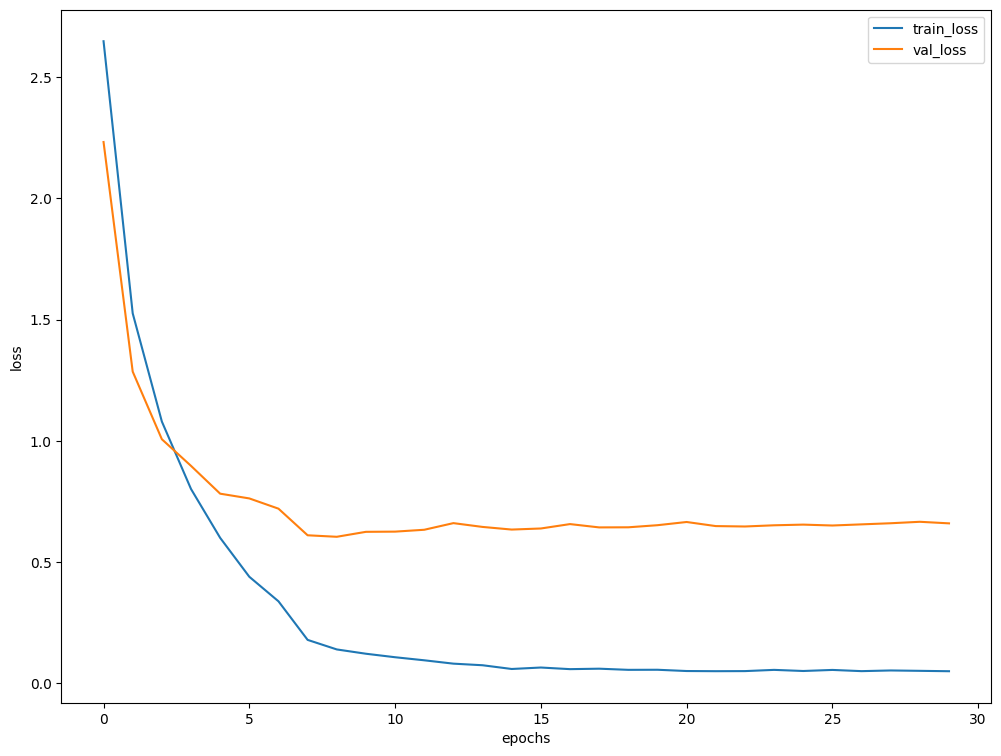

In [ ]:
visualize_train_curves(history)

Модель переобучается уже через несколько эпох, что может объясняться небольшим объёмом данных

### Валидация

In [45]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

Метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке (взяли всю выборку)

In [72]:

imgs = [val_dataset[id][0].unsqueeze(0) for id in range(5234)]

probs_ims = predict(simple_cnn, imgs)
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))


y_pred = np.argmax(probs_ims,-1)

actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in range(5234)]
preds_class = [label_encoder.classes_[y_hat] for y_hat in y_pred]
label_encoder.transform(preds_class)
f1_score(actual_labels, preds_class, average='micro')

0.9575850210164311

F1 на валидационной выборке 0,958, что уже демонстрирует высокий результат

Сделаем визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах.

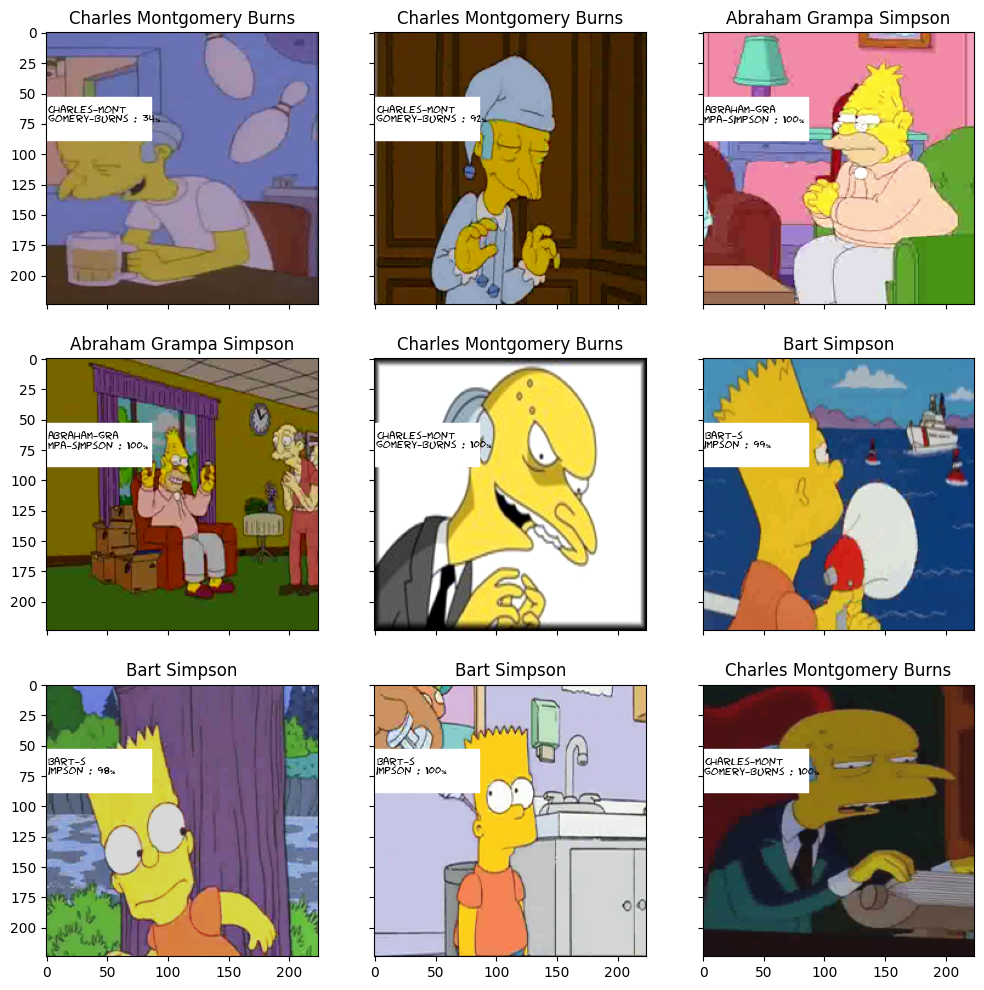

In [97]:

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Наша модель предсказывает точно и уверенно. При отсмотре попалось только пара неправильно предсказанных изображений, на которых предсказываемый персонаж был не в "плохом" ракурсе

### Submit на Kaggle

In [28]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=84)
test_filenames = [path.name for path in test_dataset.files]

In [75]:
probs = predict(simple_cnn, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

In [76]:
! ls

characters_illustration.png  history.pth	sample_data	       simple_cnn.pth  train
gdrive			     label_encoder.pkl	sample_submission.csv  testset


In [77]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('my_cnn_2.csv', index=False)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


### Результаты  пользовательской архитектуры
- Высокий результат для самописной архитектуры, предсказания точные и уверенные
- F1 на тестовой выборке на Kaggle `0.9543`
- Наблюдается переобучение




# Transfer learning
Возьмём нейронную сеть ResNet50 и попробуем несколько вариантов ее применения для нашей задачи :
* Использование готовой нейросети **"из коробки"**
* Использование нейросети как **Feature Extractor**
* **Fine Tuning** нейросети - размораживание последних слоёв
* **Differential Learning Rates** - более низкая скорость обучения для первых слоёв

ResNet50 изначально обучен на изображениях размером 224x224 пикселя, что соответствуют нашим данным

In [30]:
resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
resnet50

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 124MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Использование готовой нейросети **"из коробки"**

Изменяем только выходной полносвязный слой. По умолчанию backpropagation распространяется на все слои

Здесь и далее оставляем все параметры обучения такими же как для катомной архитектуры (CrossEntropy, AdamW, аугментации).


In [99]:

# это размерность вектора фич, поступающего на вход FC-слою
in_features = resnet50.fc.in_features
# Заменяем Fully-Connected слой на наш линейный классификатор
resnet50.fc = nn.Linear(in_features, n_classes)
resnet50 = resnet50.to(DEVICE)

In [ ]:
history_resnet50_ft = train(train_dataset, val_dataset, model=resnet50, epochs=15, batch_size=84)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 0.12635143084165734


epoch:   7%|▋         | 1/15 [06:07<1:25:43, 367.36s/it]


Epoch 001 train_loss: 0.1264     val_loss 0.2571 train_acc 0.9676 val_acc 0.9329
loss 0.0900939414694125


epoch:  13%|█▎        | 2/15 [11:43<1:15:36, 348.99s/it]


Epoch 002 train_loss: 0.0901     val_loss 0.1416 train_acc 0.9773 val_acc 0.9694
loss 0.05133890183316819


epoch:  20%|██        | 3/15 [17:07<1:07:31, 337.63s/it]


Epoch 003 train_loss: 0.0513     val_loss 0.1348 train_acc 0.9864 val_acc 0.9702
loss 0.055591160742375204


epoch:  27%|██▋       | 4/15 [22:20<1:00:07, 327.94s/it]


Epoch 004 train_loss: 0.0556     val_loss 0.1481 train_acc 0.9855 val_acc 0.9679
loss 0.03937087493760701


epoch:  33%|███▎      | 5/15 [27:36<53:54, 323.44s/it]


Epoch 005 train_loss: 0.0394     val_loss 0.1476 train_acc 0.9901 val_acc 0.9664
loss 0.03657690655495619


epoch:  40%|████      | 6/15 [32:50<48:01, 320.18s/it]


Epoch 006 train_loss: 0.0366     val_loss 0.1859 train_acc 0.9902 val_acc 0.9580
loss 0.03210966834801703


epoch:  47%|████▋     | 7/15 [38:13<42:50, 321.27s/it]


Epoch 007 train_loss: 0.0321     val_loss 0.1440 train_acc 0.9914 val_acc 0.9700
loss 0.011040709572841093


epoch:  53%|█████▎    | 8/15 [43:34<37:29, 321.29s/it]


Epoch 008 train_loss: 0.0110     val_loss 0.1064 train_acc 0.9974 val_acc 0.9813
loss 0.003928482655267885


epoch:  60%|██████    | 9/15 [48:47<31:51, 318.53s/it]


Epoch 009 train_loss: 0.0039     val_loss 0.1035 train_acc 0.9987 val_acc 0.9818
loss 0.003102829765578762


epoch:  67%|██████▋   | 10/15 [54:19<26:53, 322.72s/it]


Epoch 010 train_loss: 0.0031     val_loss 0.1016 train_acc 0.9991 val_acc 0.9813
loss 0.0024639740163001677


epoch:  73%|███████▎  | 11/15 [1:00:15<22:11, 332.86s/it]


Epoch 011 train_loss: 0.0025     val_loss 0.1039 train_acc 0.9990 val_acc 0.9834
loss 0.0014735400303524755


epoch:  80%|████████  | 12/15 [1:06:18<17:06, 342.14s/it]


Epoch 012 train_loss: 0.0015     val_loss 0.1127 train_acc 0.9994 val_acc 0.9822
loss 0.001735625595876843


epoch:  87%|████████▋ | 13/15 [1:11:47<11:15, 337.98s/it]


Epoch 013 train_loss: 0.0017     val_loss 0.1137 train_acc 0.9995 val_acc 0.9820
loss 0.0012926108620090139


epoch:  93%|█████████▎| 14/15 [1:17:08<05:32, 332.89s/it]


Epoch 014 train_loss: 0.0013     val_loss 0.1229 train_acc 0.9994 val_acc 0.9817
loss 0.001404083172071247


epoch: 100%|██████████| 15/15 [1:22:26<00:00, 329.79s/it]


Epoch 015 train_loss: 0.0014     val_loss 0.1129 train_acc 0.9996 val_acc 0.9824


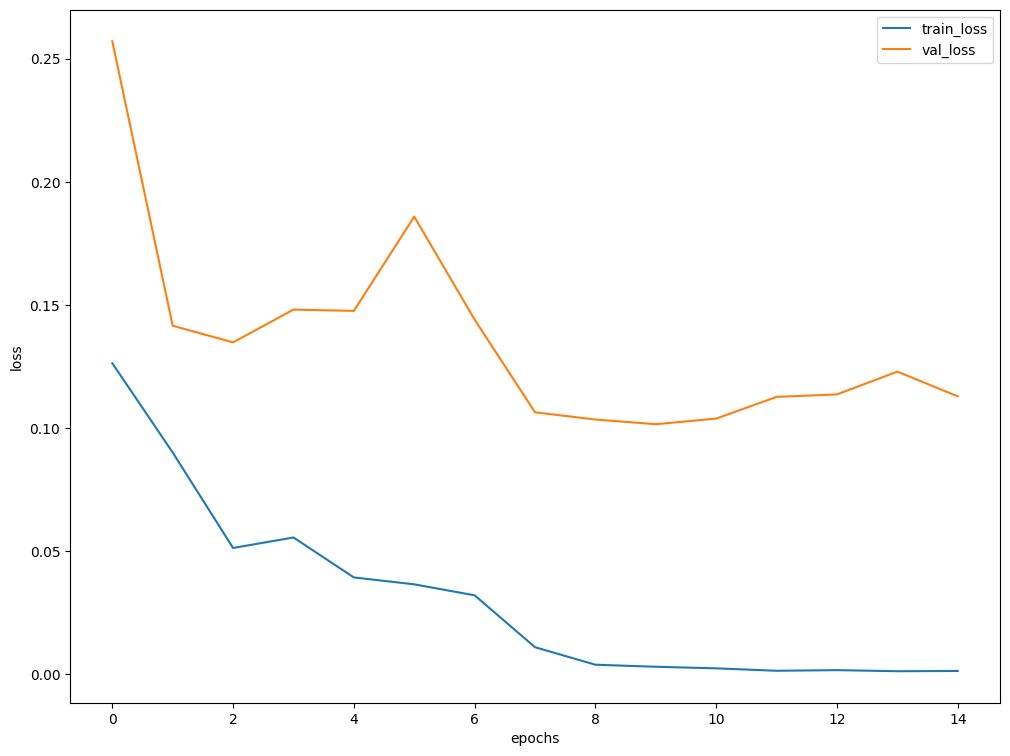

In [ ]:
visualize_train_curves(history_resnet50_ft)

In [ ]:
resnet50.load_state_dict(torch.load('ResNet_fine_tune.pth'))

In [ ]:
# submission для kaggle
probs = predict(resnet50, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('resnet50_pretrained.csv', index=False)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


#### Результаты исполользования сети **из коробки**
-
- Наблюдаем переобучение, относительно невысокое
- F1 на тестовой выборке на Kaggle: `0.99362`

Применение готовой модели для решения нашей задачи, как и ожидалось, самый эффективный способ

## Готовая сеть как **Feature Extractor**

Обучим все слои нейросети заново. Скорее всего, это способ наименее эффективен из-за размера обучающих данных в нашей задаче

In [ ]:
resnet50_extractor = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

In [ ]:
# замораживаем параметры (веса)
for param in resnet50_extractor.parameters():
    param.requires_grad = False
in_features = resnet50.fc.in_features

# Заменяем Fully-Connected слой на наш линейный классификатор
resnet50_extractor.fc = nn.Linear(in_features, n_classes)
resnet50_extractor = resnet50_extractor.to(DEVICE)

In [ ]:
history_resnet50_fe = train(train_dataset, val_dataset, model=resnet50_extractor,
                            epochs=20, batch_size=84)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 2.7242627073240944


epoch:   5%|▌         | 1/20 [03:37<1:08:53, 217.57s/it]


Epoch 001 train_loss: 2.7243     val_loss 2.6165 train_acc 0.3161 val_acc 0.4024
loss 2.5008478073551665


epoch:  10%|█         | 2/20 [07:12<1:04:52, 216.25s/it]


Epoch 002 train_loss: 2.5008     val_loss 2.4285 train_acc 0.4653 val_acc 0.4958
loss 2.3161837594495003


epoch:  15%|█▌        | 3/20 [10:49<1:01:17, 216.35s/it]


Epoch 003 train_loss: 2.3162     val_loss 2.2633 train_acc 0.5398 val_acc 0.5485
loss 2.1563362570444986


epoch:  20%|██        | 4/20 [14:24<57:36, 216.03s/it]


Epoch 004 train_loss: 2.1563     val_loss 2.1294 train_acc 0.5780 val_acc 0.5722
loss 2.0184991409827346


epoch:  25%|██▌       | 5/20 [18:01<54:01, 216.11s/it]


Epoch 005 train_loss: 2.0185     val_loss 2.0107 train_acc 0.6074 val_acc 0.6016
loss 1.9014131703022308


epoch:  30%|███       | 6/20 [21:36<50:22, 215.90s/it]


Epoch 006 train_loss: 1.9014     val_loss 1.9042 train_acc 0.6302 val_acc 0.6229
loss 1.7969486771271377


epoch:  35%|███▌      | 7/20 [25:12<46:45, 215.81s/it]


Epoch 007 train_loss: 1.7969     val_loss 1.8178 train_acc 0.6531 val_acc 0.6343
loss 1.7363161132687845


epoch:  40%|████      | 8/20 [28:49<43:13, 216.12s/it]


Epoch 008 train_loss: 1.7363     val_loss 1.8077 train_acc 0.6629 val_acc 0.6326
loss 1.7280246394099275


epoch:  45%|████▌     | 9/20 [32:23<39:33, 215.74s/it]


Epoch 009 train_loss: 1.7280     val_loss 1.7953 train_acc 0.6625 val_acc 0.6414
loss 1.7187972318686469


epoch:  50%|█████     | 10/20 [35:59<35:56, 215.66s/it]


Epoch 010 train_loss: 1.7188     val_loss 1.7871 train_acc 0.6702 val_acc 0.6408
loss 1.7091142254898113


epoch:  55%|█████▌    | 11/20 [39:34<32:18, 215.40s/it]


Epoch 011 train_loss: 1.7091     val_loss 1.7796 train_acc 0.6662 val_acc 0.6475
loss 1.7007584306903536


epoch:  60%|██████    | 12/20 [43:08<28:40, 215.10s/it]


Epoch 012 train_loss: 1.7008     val_loss 1.7698 train_acc 0.6673 val_acc 0.6412
loss 1.6939023890323082


epoch:  65%|██████▌   | 13/20 [46:44<25:07, 215.42s/it]


Epoch 013 train_loss: 1.6939     val_loss 1.7586 train_acc 0.6699 val_acc 0.6456
loss 1.6857076970792377


epoch:  70%|███████   | 14/20 [50:19<21:30, 215.11s/it]


Epoch 014 train_loss: 1.6857     val_loss 1.7606 train_acc 0.6723 val_acc 0.6391
loss 1.6760336010082033


epoch:  75%|███████▌  | 15/20 [53:54<17:55, 215.07s/it]


Epoch 015 train_loss: 1.6760     val_loss 1.7500 train_acc 0.6723 val_acc 0.6477
loss 1.6754070757771686


epoch:  80%|████████  | 16/20 [57:29<14:20, 215.17s/it]


Epoch 016 train_loss: 1.6754     val_loss 1.7503 train_acc 0.6723 val_acc 0.6437
loss 1.6771065830478198


epoch:  85%|████████▌ | 17/20 [1:01:04<10:45, 215.06s/it]


Epoch 017 train_loss: 1.6771     val_loss 1.7483 train_acc 0.6742 val_acc 0.6477
loss 1.6751646916269003


epoch:  90%|█████████ | 18/20 [1:04:39<07:10, 215.08s/it]


Epoch 018 train_loss: 1.6752     val_loss 1.7464 train_acc 0.6739 val_acc 0.6511
loss 1.6738424175628028


epoch:  95%|█████████▌| 19/20 [1:08:14<03:34, 214.96s/it]


Epoch 019 train_loss: 1.6738     val_loss 1.7498 train_acc 0.6741 val_acc 0.6469
loss 1.6726501087556487


epoch: 100%|██████████| 20/20 [1:11:47<00:00, 215.39s/it]


Epoch 020 train_loss: 1.6727     val_loss 1.7488 train_acc 0.6741 val_acc 0.6439


In [1]:
visualize_train_curves(history_resnet50_fe) 

In [ ]:
probs = predict(resnet50_extractor, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('resnet50_extractor.csv', index=False)
my_submit.head()

#### Результаты использования архитектуры сети как **Feature Extractor**

- Переобучения не наблюдаем
- Метрика при обучении низкая относительно других способов - на Kaggle не тестировалось

## Fine tuning смешанный способ

Мы будем обучать не только последний **fully connected** слой, но и 14 предпоследних.

In [ ]:
resnet50_mixed = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

In [ ]:
# Определение количества слоев, которые нужно заморозить
layers_to_unfreeze = 15

# Получение списка всех параметров модели
all_parameters = list(resnet50_mixed.parameters())

# Заморозка всех слоев, кроме последних (Выключаем подсчет градиентов для слоев, которые не будем обучать)
for param in all_parameters[:-layers_to_unfreeze]:
    param.requires_grad = False

# Заменяем Fully-Connected слой на наш линейный классификатор
resnet50_mixed.fc = nn.Linear(in_features, n_classes)
resnet50_mixed = resnet50_mixed.to(DEVICE)

In [ ]:
# проверим
for param in resnet50_mixed.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
history_resnet50_mix = train(train_dataset, val_dataset, model=resnet50_mixed,
                             epochs=15, batch_size=84)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 2.2138259881726876


epoch:   7%|▋         | 1/15 [04:03<56:44, 243.14s/it]


Epoch 001 train_loss: 2.2138     val_loss 1.1341 train_acc 0.4594 val_acc 0.7478
loss 0.699365719347002


epoch:  13%|█▎        | 2/15 [07:48<50:28, 232.95s/it]


Epoch 002 train_loss: 0.6994     val_loss 0.5922 train_acc 0.8236 val_acc 0.8431
loss 0.3694353393516963


epoch:  20%|██        | 3/15 [11:22<44:47, 223.99s/it]


Epoch 003 train_loss: 0.3694     val_loss 0.4809 train_acc 0.9014 val_acc 0.8718
loss 0.24977993979244234


epoch:  27%|██▋       | 4/15 [14:54<40:12, 219.30s/it]


Epoch 004 train_loss: 0.2498     val_loss 0.4236 train_acc 0.9313 val_acc 0.8903
loss 0.1625790686332175


epoch:  33%|███▎      | 5/15 [18:26<36:07, 216.73s/it]


Epoch 005 train_loss: 0.1626     val_loss 0.4106 train_acc 0.9531 val_acc 0.8974
loss 0.11272874349945708


epoch:  40%|████      | 6/15 [21:58<32:15, 215.08s/it]


Epoch 006 train_loss: 0.1127     val_loss 0.4094 train_acc 0.9689 val_acc 0.9043
loss 0.08272878788788916


epoch:  47%|████▋     | 7/15 [25:30<28:31, 213.95s/it]


Epoch 007 train_loss: 0.0827     val_loss 0.4733 train_acc 0.9757 val_acc 0.8947
loss 0.03757486696136674


epoch:  53%|█████▎    | 8/15 [29:01<24:52, 213.22s/it]


Epoch 008 train_loss: 0.0376     val_loss 0.4101 train_acc 0.9914 val_acc 0.9110
loss 0.03023990059330897


epoch:  60%|██████    | 9/15 [32:41<21:31, 215.21s/it]


Epoch 009 train_loss: 0.0302     val_loss 0.4103 train_acc 0.9926 val_acc 0.9110
loss 0.025883035822569494


epoch:  67%|██████▋   | 10/15 [36:17<17:57, 215.41s/it]


Epoch 010 train_loss: 0.0259     val_loss 0.4135 train_acc 0.9941 val_acc 0.9123
loss 0.02227566276367105


epoch:  73%|███████▎  | 11/15 [39:50<14:19, 214.88s/it]


Epoch 011 train_loss: 0.0223     val_loss 0.4248 train_acc 0.9946 val_acc 0.9142
loss 0.02024740798038639


epoch:  80%|████████  | 12/15 [43:27<10:46, 215.54s/it]


Epoch 012 train_loss: 0.0202     val_loss 0.4378 train_acc 0.9951 val_acc 0.9135
loss 0.01814796304685816


epoch:  87%|████████▋ | 13/15 [47:03<07:11, 215.67s/it]


Epoch 013 train_loss: 0.0181     val_loss 0.4326 train_acc 0.9957 val_acc 0.9131
loss 0.01696432458774108


epoch:  93%|█████████▎| 14/15 [50:42<03:36, 216.67s/it]


Epoch 014 train_loss: 0.0170     val_loss 0.4714 train_acc 0.9956 val_acc 0.9142
loss 0.015179400498141083


epoch: 100%|██████████| 15/15 [54:15<00:00, 217.04s/it]


Epoch 015 train_loss: 0.0152     val_loss 0.4328 train_acc 0.9969 val_acc 0.9171


In [ ]:
torch.save(resnet50_mixed.state_dict(), 'ResNet_mix.pth')

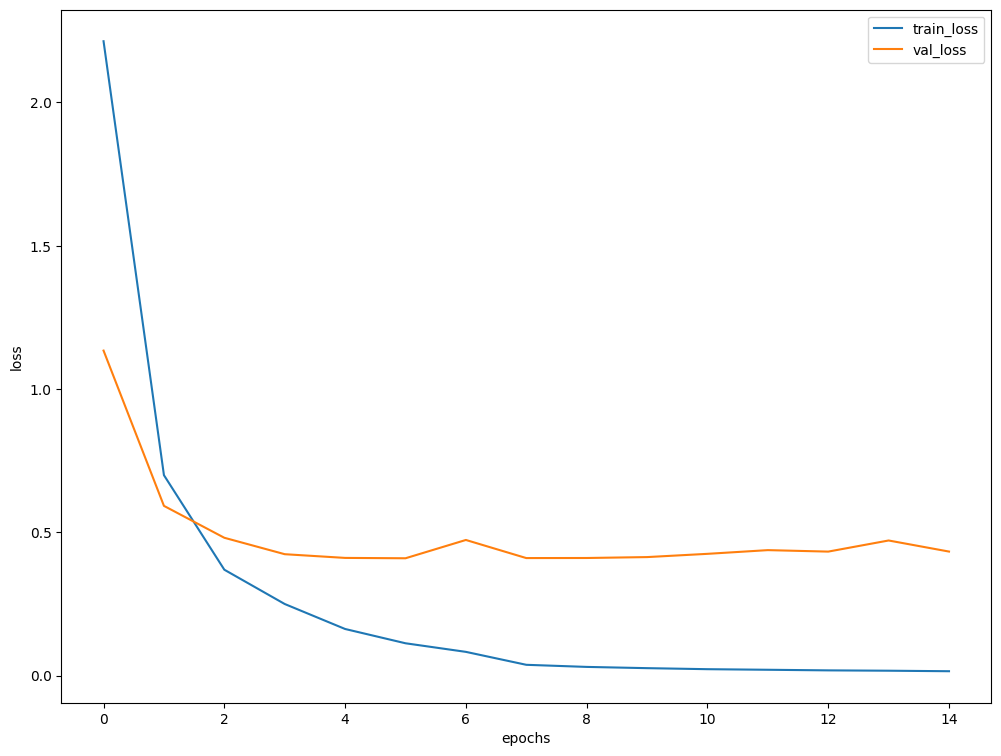

In [ ]:
visualize_train_curves(history_resnet50_mix)

In [ ]:
# submission для kaggle
probs = predict(resnet50_mixed, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('resnet50_mixed.csv', index=False)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


#### Результаты Fine Tuning - **Unfreeze 15 last layers**

- Наблюдаем переобучение
- F1 на тестовой выборке на Kaggle: `0.92348`


## **Differential Learning Rates**

Установим разные шаги обучения для разных слоев - не замораживаем все первые слои, а делаем так, чтобы шаг градиента на них был меньше.


In [ ]:
resnet_diff_lr = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

in_features = resnet_diff_lr.fc.in_features
all_parameters = list(resnet_diff_lr.parameters())


resnet_diff_lr.fc = nn.Linear(in_features, n_classes)
resnet_diff_lr = resnet_diff_lr.to(DEVICE)

optimizer_diff_lr = torch.optim.AdamW(params=[
        {"params": resnet_diff_lr.fc.parameters()},
        {"params": all_parameters[:-2], "lr": 1e-5,}
    ],
    lr=1e-4
)

In [ ]:
history_resnet50_diff_lr = train(train_dataset, val_dataset, model=resnet_diff_lr,
                                 epochs=15, batch_size=84, optimizer=optimizer_diff_lr)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 2.807155763353464


epoch:   7%|▋         | 1/15 [05:43<1:20:02, 343.03s/it]


Epoch 001 train_loss: 2.8072     val_loss 1.8550 train_acc 0.2880 val_acc 0.6565
loss 0.7217246795358974


epoch:  13%|█▎        | 2/15 [11:06<1:11:51, 331.68s/it]


Epoch 002 train_loss: 0.7217     val_loss 0.3654 train_acc 0.8400 val_acc 0.9037
loss 0.2634831179391124


epoch:  20%|██        | 3/15 [16:22<1:04:50, 324.17s/it]


Epoch 003 train_loss: 0.2635     val_loss 0.2528 train_acc 0.9336 val_acc 0.9360
loss 0.14564663292361382


epoch:  27%|██▋       | 4/15 [22:14<1:01:26, 335.18s/it]


Epoch 004 train_loss: 0.1456     val_loss 0.2260 train_acc 0.9624 val_acc 0.9408
loss 0.09254722952552263


epoch:  33%|███▎      | 5/15 [27:49<55:51, 335.17s/it]


Epoch 005 train_loss: 0.0925     val_loss 0.2170 train_acc 0.9770 val_acc 0.9480
loss 0.0554097449877181


epoch:  40%|████      | 6/15 [32:59<49:01, 326.86s/it]


Epoch 006 train_loss: 0.0554     val_loss 0.2258 train_acc 0.9855 val_acc 0.9488
loss 0.04218463706197536


epoch:  47%|████▋     | 7/15 [38:12<42:57, 322.20s/it]


Epoch 007 train_loss: 0.0422     val_loss 0.2269 train_acc 0.9894 val_acc 0.9480
loss 0.019385581432643992


epoch:  53%|█████▎    | 8/15 [43:21<37:04, 317.86s/it]


Epoch 008 train_loss: 0.0194     val_loss 0.1993 train_acc 0.9959 val_acc 0.9559
loss 0.01545367787389048


epoch:  60%|██████    | 9/15 [48:29<31:28, 314.76s/it]


Epoch 009 train_loss: 0.0155     val_loss 0.2039 train_acc 0.9974 val_acc 0.9587
loss 0.013394673538278412


epoch:  67%|██████▋   | 10/15 [53:34<25:59, 312.00s/it]


Epoch 010 train_loss: 0.0134     val_loss 0.1974 train_acc 0.9976 val_acc 0.9572
loss 0.010846918774448362


epoch:  73%|███████▎  | 11/15 [58:40<20:40, 310.10s/it]


Epoch 011 train_loss: 0.0108     val_loss 0.2054 train_acc 0.9982 val_acc 0.9570
loss 0.010154748529357917


epoch:  80%|████████  | 12/15 [1:03:47<15:27, 309.09s/it]


Epoch 012 train_loss: 0.0102     val_loss 0.2050 train_acc 0.9984 val_acc 0.9576
loss 0.009314666862836074


epoch:  87%|████████▋ | 13/15 [1:08:52<10:15, 307.90s/it]


Epoch 013 train_loss: 0.0093     val_loss 0.2105 train_acc 0.9983 val_acc 0.9589
loss 0.0077430927845584105


epoch:  93%|█████████▎| 14/15 [1:13:57<05:07, 307.07s/it]


Epoch 014 train_loss: 0.0077     val_loss 0.2126 train_acc 0.9989 val_acc 0.9583
loss 0.007724286742821996


epoch: 100%|██████████| 15/15 [1:19:03<00:00, 316.25s/it]


Epoch 015 train_loss: 0.0077     val_loss 0.2224 train_acc 0.9987 val_acc 0.9545


In [ ]:
torch.save(resnet_diff_lr.state_dict(), 'ResNet_diff_lr.pth')

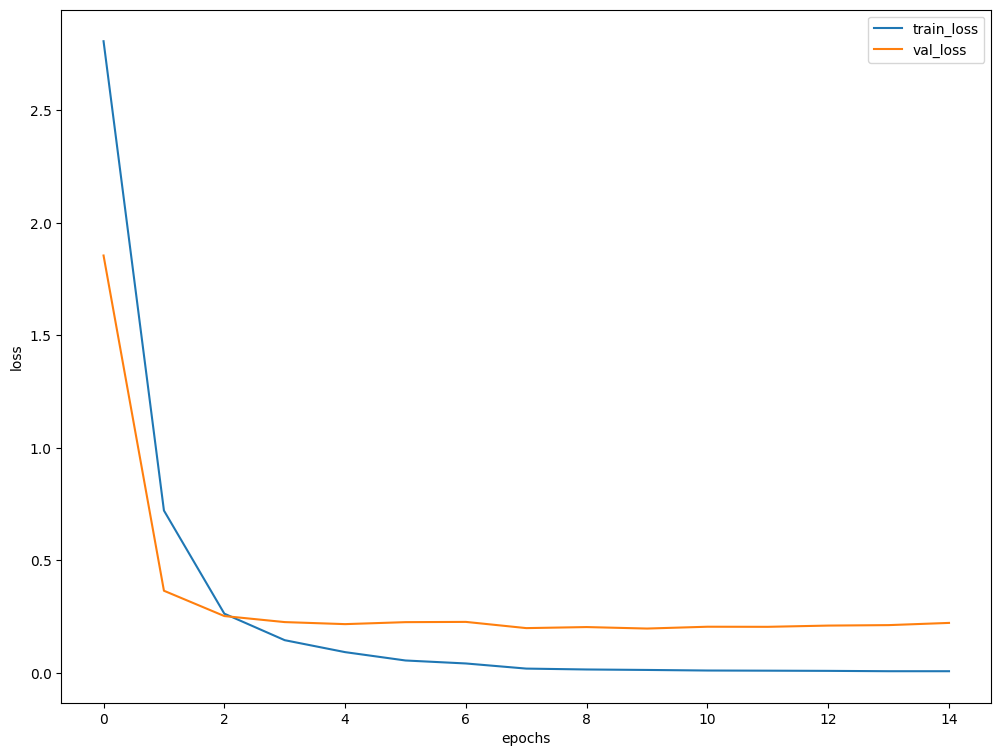

In [ ]:
visualize_train_curves(history_resnet50_diff_lr)

In [ ]:
# submission для kaggle
probs = predict(resnet_diff_lr, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('resnet_diff_lr.csv', index=False)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


#### Результаты Fine Tuning **Differential Learning Rates**

- Наблюдаем переобучение
- F1 на тестовой выборке на Kaggle: `0.97236`

# Итоги
Решалась задача классификации изображений по присутствующему на нём персонаже из мультсериала Симпсоны. Размер обучающей выборки ~ 20 тыс. изображений, тестовой выборки на Kaggle - 991 шт. В обучающем датасете дисбаланс классов, в этой работе мы это не учитывали.
1. Улучшенная архитектура базовой нейронной сети показала достаточно высокий результат F1 = 0.9543
Для улучшения применено: увеличение каналов свёрточных слоёв, добавление слоёв BatchNorm, Dropout, скрытого полносвязного слоя, увеличение количество эпох, batch_size, использование lr_sheduler, аугментации изображений.

2. Самый высокий результат дало применение Transfer Learning, а именно предобученной на ImageNet модели ResNet50 "из коробки" F1 = 0.99362. Обучение проводилось с  параметрами аналогичными предыдущему пункту